In [1]:
# Boolean aliases ----
T = True
F = False
#Import libraries ----
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_theme()
from pathlib import Path
# Personal libraries ----
from networks.structure import STR
from modules.hierarmerge import Hierarchy
from networks.toy import TOY
from modules.colregion import colregion
from modules.tribrain import triPred
from various.network_tools import *
from modules.discovery import discovery_7
from various.nearest_neighbors import neighbor_areas

# Declare global variables ----
linkage = "single"
nlog10 = F
lookup = F
prob = F
cut = F
subject = "MAC"
structure = "FLN"
mode = "ZERO"
distance = "tracto16"
nature = "original"
imputation_method = ""
topology = "MIX"
discovery = "discovery_7"
mapping = "trivial"
index  = "Hellinger2"
bias = 0.
alpha = 0.
version = "57"+"d"+"106"
__nodes__ = 57
__inj__ = 57

NET = STR[f"{subject}{__inj__}"](
    linkage, mode,
    nlog10 = nlog10,
    structure = structure,
    lookup = lookup,
    version = version,
    nature = nature,
    model = imputation_method,
    distance = distance,
    inj = __inj__,
    discovery = discovery,
    topology = topology,
    index = index,
    mapping = mapping,
    cut = cut,
    b = bias,
    alpha = alpha
)

NET_H = read_class(NET.pickle_path, "hanalysis")

nearest_neighbors = neighbor_areas[f"{subject}{NET.rows}"]

../pickle/MAC/57d106/FLN/original/tracto16/57/SINGLE_106_57/ZERO/MIX_Hellinger2_trivial/b_0.0/discovery_7/hanalysis.pk


>>> Iteration: 0
>>> kfold: 0
>>> Computing the connection probabilities for known targets.
>>> Predicting all target distributions by triangulation.
>>> Setup complete.
>>> Generate count random matrix.
>>> Done.
>>> kfold: 1
>>> Computing the connection probabilities for known targets.
>>> Predicting all target distributions by triangulation.
>>> Setup complete.
>>> Generate count random matrix.
>>> Done.
>>> kfold: 2
>>> Computing the connection probabilities for known targets.
>>> Predicting all target distributions by triangulation.
>>> Setup complete.
>>> Generate count random matrix.
>>> Done.
>>> kfold: 3
>>> Computing the connection probabilities for known targets.
>>> Predicting all target distributions by triangulation.
>>> Setup complete.
>>> Generate count random matrix.
>>> Done.
>>> kfold: 4
>>> Computing the connection probabilities for known targets.
>>> Predicting all target distributions by triangulation.
>>> Setup complete.
>>> Generate count random matrix.
>>> Done

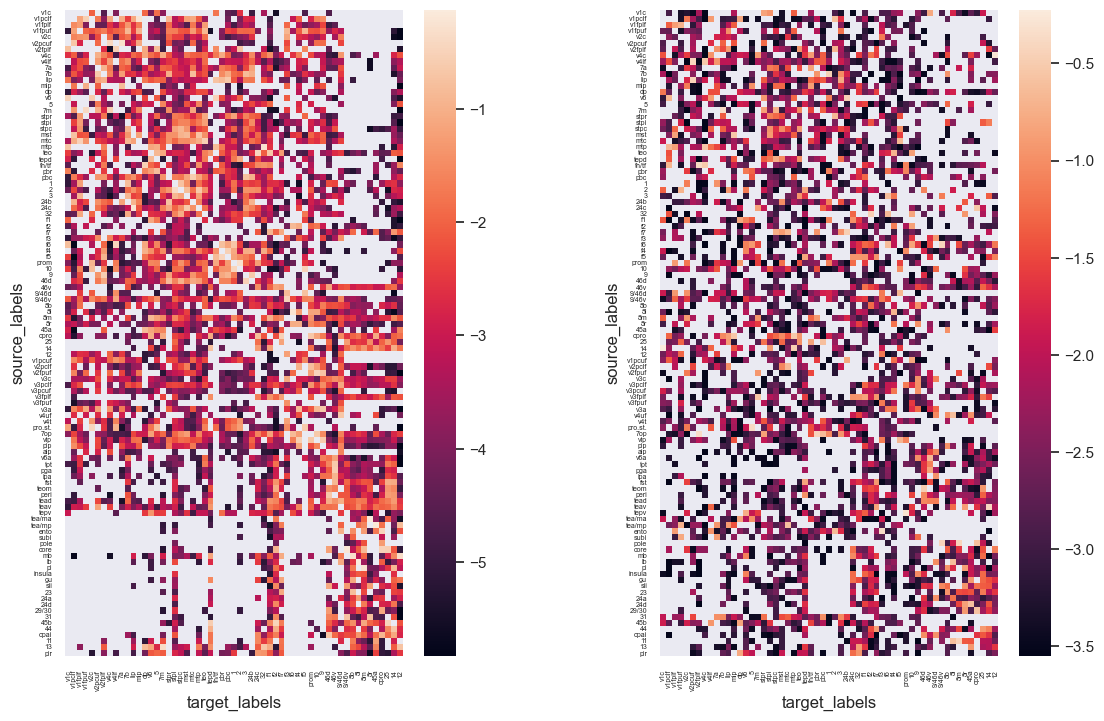

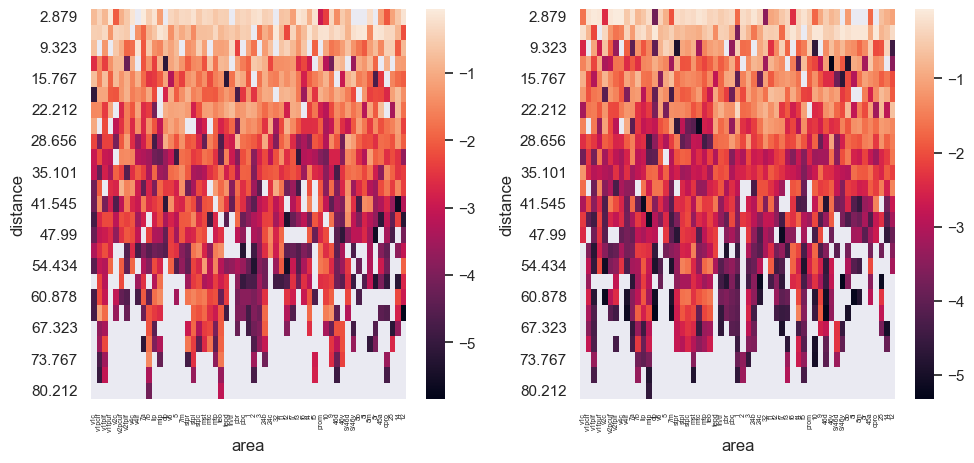

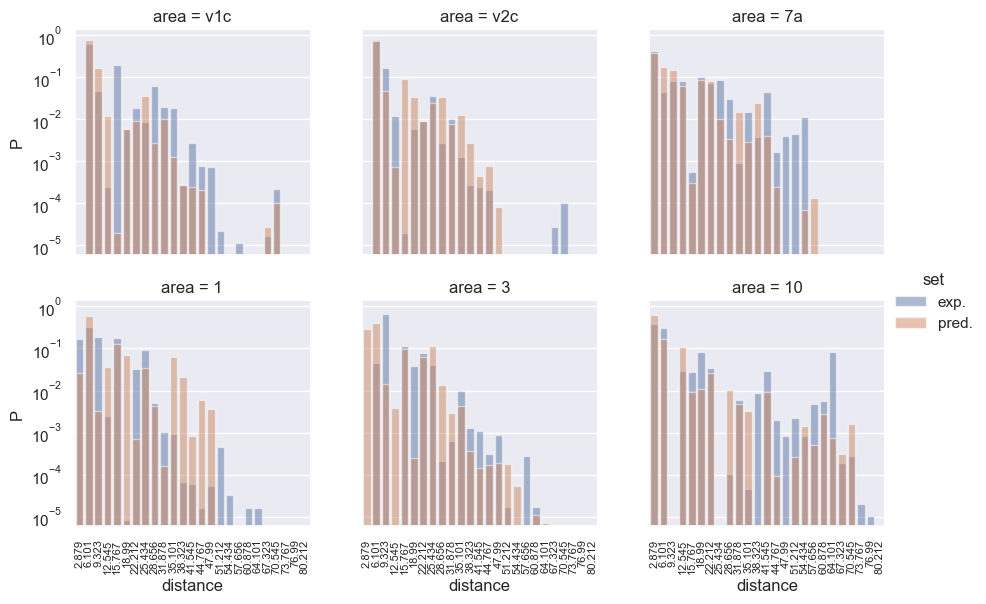

In [2]:
# Validation 
dist_bins = 25
nb_iterations = 1
score = "_S"

# Kfold cross-validation
K = 5
known_nodes_range = np.arange(NET.nodes)
testset_boundaries = np.linspace(0, NET.nodes, K + 1)
testset_boundaries = [int(t) for t in testset_boundaries]


target_learned_distributions = np.zeros((dist_bins, NET.nodes))

unknown_nodes_range = np.arange(NET.nodes, NET.rows)
large_predicted_known_graph = []
large_omega_graph = []
large_D12_graph = []
large_mean_error_graph = []
large_rmean_error_graph = []

for it in np.arange(nb_iterations):
  print(f">>> Iteration: {it}")
  predicted_known_graph = np.zeros(NET.C.shape)

  permuted_known_nodes = np.random.permutation(known_nodes_range)

  for k in np.arange(K):
    print(f">>> kfold: {k}")
    testset_nodes = permuted_known_nodes[testset_boundaries[k]:testset_boundaries[k+1]]
    trainingset_nodes = np.array([t for t in permuted_known_nodes if t not in testset_nodes])

    set_nodes_order = np.hstack([trainingset_nodes, testset_nodes])
    total_set_nodes_order = np.hstack([trainingset_nodes, testset_nodes, unknown_nodes_range])

    nb_training_nodes = trainingset_nodes.shape[0]

    perm_area_labels = NET.struct_labels[total_set_nodes_order]

    Dset = NET.D.copy()
    Cset = NET.CC.copy()

    Dset = Dset[total_set_nodes_order, :][:, total_set_nodes_order]
    Cset = Cset[:, set_nodes_order][total_set_nodes_order, :]

    modelk = triPred(
      Dset, Cset, nearest_neighbors, perm_area_labels, perm_area_labels[:nb_training_nodes], dist_bins=dist_bins
    )

    modelk.setup_engine()


    target_learned_distributions[:, testset_nodes] = modelk.target_distance_distributions[nb_training_nodes:NET.nodes, :].T   

    random_fln_matrix = modelk.generate_count_matrix(target_density=0.59)
    random_fln_matrix /= np.sum(random_fln_matrix, axis=0)

    predicted_known_graph[:, testset_nodes] = random_fln_matrix[:, nb_training_nodes:NET.nodes]

  # Network heatmaps

  fig, ax = plt.subplots(1, 2)

  experimental_fln_df = adj2df(NET.A)
  experimental_fln_df["weight"].loc[experimental_fln_df["weight"] == 0] = np.nan
  experimental_fln_df["weight"] = np.log10(experimental_fln_df["weight"])
  experimental_fln_df["source_labels"] = NET.struct_labels[experimental_fln_df["source"]]
  experimental_fln_df["target_labels"] = NET.struct_labels[experimental_fln_df["target"]]

  random_fln_df = adj2df(predicted_known_graph)
  random_fln_df["weight"].loc[random_fln_df["weight"] == 0] = np.nan
  random_fln_df["weight"] = np.log10(random_fln_df["weight"])
  random_fln_df["source_labels"] = NET.struct_labels[random_fln_df["source"]]
  random_fln_df["target_labels"] = NET.struct_labels[random_fln_df["target"]]

  sns.heatmap(
    data = experimental_fln_df.pivot(index="source_labels", columns="target_labels", values="weight"),
    xticklabels=NET.struct_labels[:NET.nodes],
    yticklabels=NET.struct_labels,
    ax=ax[0]
  )

  sns.heatmap(
    data = random_fln_df.pivot(index="source_labels", columns="target_labels", values="weight"),
    xticklabels=NET.struct_labels[:NET.nodes],
    yticklabels=NET.struct_labels,
    ax=ax[1]
  )

  for ax_index in ax:
    ax_index.set_xticklabels(ax_index.get_xticklabels(), fontsize=5)
    ax_index.set_yticklabels(ax_index.get_yticklabels(), fontsize=5)

  fig.tight_layout()
  fig.set_figwidth(12.5)
  fig.set_figheight(8)

  model_exp = triPred(NET.D, NET.CC, nearest_neighbors, NET.struct_labels, NET.struct_labels[:NET.nodes], dist_bins=dist_bins)
  model_exp.setup_engine()
  # print(np.sum(NET.CC))

  # Neuronal decay probability (NDP) versus time heatmaps.

  target_experimental_distributions = pd.DataFrame()
  for i in known_nodes_range:
    target_experimental_distributions = pd.concat(
      [
        target_experimental_distributions,
        pd.DataFrame(
          {
            "area" : [NET.struct_labels[i]] * model_exp.dist_bins,
            "P" : model_exp.target_distance_distributions[i],
            "distance" : np.round(model_exp.distance_bin_centers, 3)
          }
        )
      ], ignore_index=True
    )

  target_experimental_distributions["P"].loc[target_experimental_distributions["P"] == 0] = np.nan
  target_experimental_distributions["P"] = np.log10(target_experimental_distributions["P"])

  target_learned2_distributions = pd.DataFrame()
  for i in known_nodes_range:
    target_learned2_distributions = pd.concat(
      [
        target_learned2_distributions,
        pd.DataFrame(
          {
            "area" : [NET.struct_labels[i]] * model_exp.dist_bins,
            "P" : target_learned_distributions[:, i],
            "distance" : np.round(model_exp.distance_bin_centers, 3)
          }
        )
      ], ignore_index=True
    )

  target_learned2_distributions["P"].loc[target_learned2_distributions["P"] == 0] = np.nan
  target_learned2_distributions["P"] = np.log10(target_learned2_distributions["P"])

  fig, ax = plt.subplots(1, 2)

  sns.heatmap(
    data=target_experimental_distributions.pivot(index="distance", columns="area", values="P"),
    xticklabels=NET.struct_labels[:NET.nodes],
    ax=ax[0]
  )
  sns.heatmap(
    data=target_learned2_distributions.pivot(index="distance", columns="area", values="P"),
    xticklabels=NET.struct_labels[:NET.nodes],
    ax=ax[1]
  )

  ax[0].set_xticklabels(ax[0].get_xticklabels(), fontsize=5)
  ax[1].set_xticklabels(ax[1].get_xticklabels(), fontsize=5)
  fig.set_figwidth(10)
  fig.tight_layout()

  # Comparing experimental and predicted NPDs.

  target_experimental_distributions["set"] = "exp."
  target_learned2_distributions["set"] = "pred."
  ndp_data = pd.concat([target_experimental_distributions, target_learned2_distributions])
  ndp_data["P"] = 10 ** (ndp_data["P"])

  random_area_selection = np.random.choice(known_nodes_range, 6, replace=False)
  # random_area_selection = NET.struct_labels[random_area_selection]
  random_area_selection = ["v1c", "v2c", "7a", "1", "3", "10"]

  g = sns.FacetGrid(
    data=ndp_data.loc[np.isin(ndp_data["area"], random_area_selection)],
    col="area",
    col_wrap=3,
    hue="set"
  )

  g.map_dataframe(
    sns.barplot,
    x="distance",
    y="P",
    alpha=0.5,
    dodge=T
  )

  g.add_legend()

  for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=8)
    ax.set_yscale('log')

  ###########

  # large_predicted_known_graph.append(predicted_known_graph)
  # large_mean_error_graph.append(
  #   np.log(NET.A.ravel()) - np.log(predicted_known_graph.ravel())
  # )
  # large_rmean_error_graph.append(
  #   [(expw - predw) / expw for expw, predw in zip(np.log(NET.A.ravel()), np.log(predicted_known_graph.ravel()))]
  # )
  # large_D12_graph.append(
  #   [
  #     -2 * np.log(np.sum([np.sqrt(pexp * ppred) for pexp, ppred in zip(NET.A[:, target_node], predicted_known_graph[:, target_node])])) for target_node in known_nodes_range
  #   ]
  # )

  # Community analysis

  RANDOM_NET = TOY(
    predicted_known_graph, linkage, index=index
  )
  RANDOM_NET.set_labels(NET.struct_labels)

  H = Hierarchy(
    RANDOM_NET, RANDOM_NET.A, RANDOM_NET.A, NET.D,
    __nodes__, linkage, mode, lookup=lookup, index=index
  )

  H.BH_features_cpp_no_mu()
  H.la_abre_a_merde_cpp(H.BH[0])

  L = colregion(NET, labels_name=f"labels{__inj__}")
  H.set_colregion(L)

  k, r, _ = get_best_kr_equivalence(score, H)
  rlabels = get_labels_from_Z(H.Z, r)
  rlabels = skim_partition(rlabels)
  _, covers, noc_sizes, rlabels2 = discovery_7(
    H, k, rlabels, direction="both", index=index
  )
  cover = omega_index_format(rlabels2, covers, H.colregion.labels[:H.nodes])
  large_omega_graph.append(omega_index(cover, NET_H.cover["both"][score]))
  
